In [186]:
# !pip3 install datasets
# !pip install -q condacolab
# import condacolab
# condacolab.install()

In [187]:
# import condacolab
# condacolab.check()

In [188]:
# !conda install -c conda-forge cyvlfeat

Попробуем разобраться с задачей классификации.

In [189]:
from datasets import load_dataset

ds = load_dataset("luli0034/music-tags-to-spectrogram", split='train')

Resolving data files:   0%|          | 0/25 [00:00<?, ?it/s]

In [190]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn
import cyvlfeat
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, accuracy_score
from datasets import load_dataset
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.utils.data.dataloader import default_collate
import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from scipy.spatial.distance import cdist

In [191]:
BATCH_SIZE = 64
IMAGE_SIZE = 512

subset_size = int(len(ds))
# subset_size = 50
subset = ds.select(range(subset_size), )
print(subset)
ds = subset

Dataset({
    features: ['image', 'text'],
    num_rows: 1543
})


Хотим попробовать использовать SIFT для выделения признаков, чтобы эффективнее "кодировать" картинку.

In [192]:
ds = ds.train_test_split(test_size=0.2)

In [193]:
ds_train, ds_test = ds["train"], ds["test"]

Посмотрим на выделение keypoints на примере маленького изображения

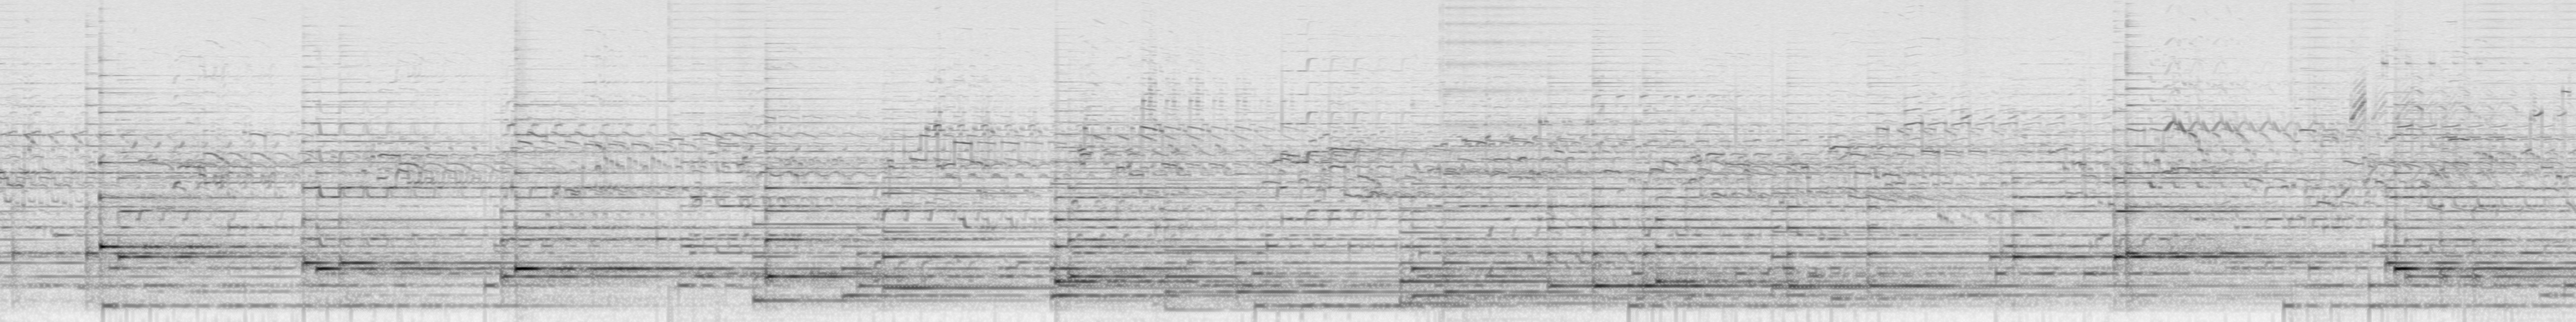

In [194]:
ds_train[0]["image"].crop((1000, 0, 5000, 500))

In [195]:
ds_train[0]["text"]

'soundtrack ambient electronica'

In [196]:
import cv2

image = ds_train[0]["image"]
image = np.array(image)
image = image[:, :, ::-1].copy()


height, width, _ = image.shape

crop_width = width // 5
start_x = width // 2 - width // (5 * 2)
end_x = start_x + crop_width

cropped_image = image[:, start_x:end_x]

gray= cv2.cvtColor(cropped_image,cv2.COLOR_BGR2GRAY)

sift = cv2.SIFT_create(nfeatures=1000)
kp, desc = sift.detectAndCompute(gray, None)

img=cv2.drawKeypoints(gray ,
                      kp ,
                      image ,
                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

cv2.imwrite('image-with-keypoints.jpg', img)

True

In [197]:
desc.shape

(1001, 128)

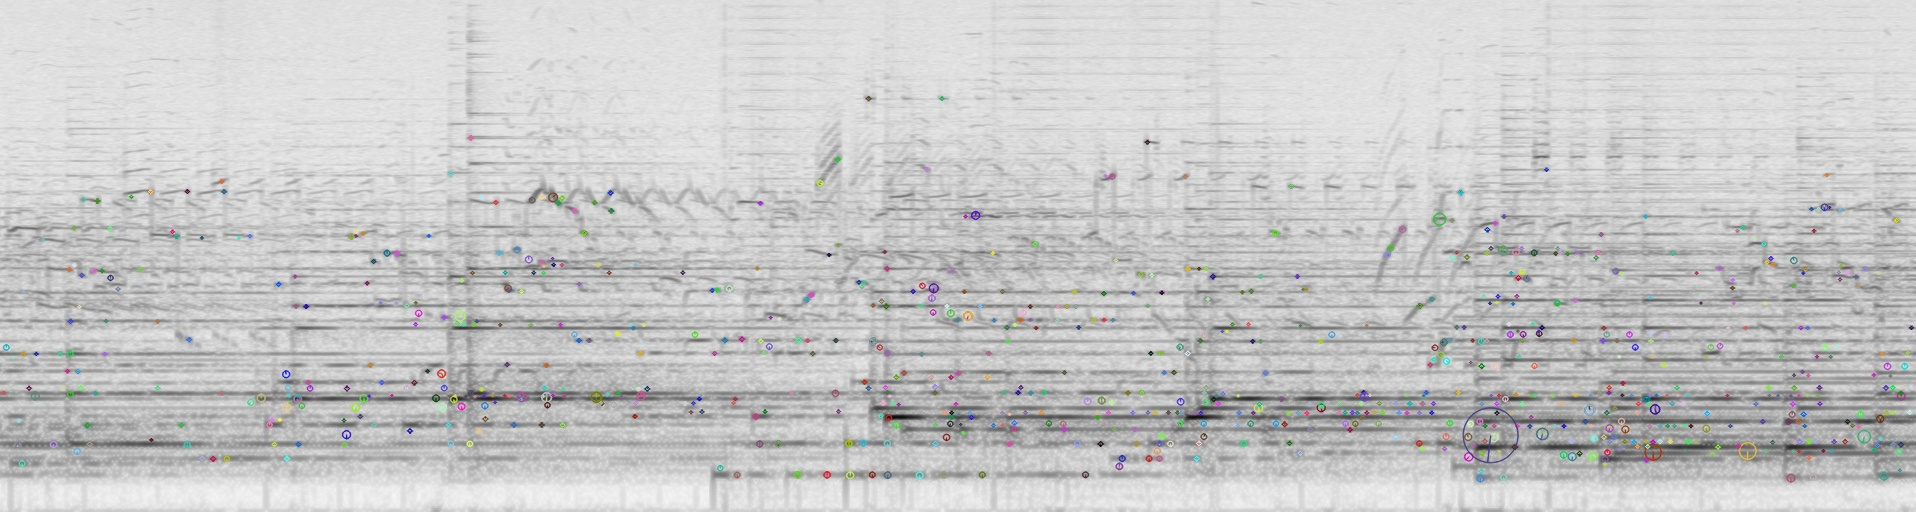

In [198]:
from IPython.display import Image
Image('image-with-keypoints.jpg')

In [199]:
def extract_cv_sift(image, nfeatures=1000):
    sift = cv2.SIFT_create(nfeatures=nfeatures)
    kp, descriptors = sift.detectAndCompute(image, None)
    if len(kp) > nfeatures:
        kp = kp[:nfeatures]
        descriptors = descriptors[:nfeatures]
    return descriptors


def preprocess_image(image):
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    if len(image.shape) == 3:
        height, width, _ = image.shape
        image_part = 7
        crop_width = width // image_part
        start_x = width // 2 - width // (image_part * 2)
        end_x = start_x + crop_width
        cropped_image = image[:, start_x:end_x]
        image = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2GRAY)
    return image


In [200]:
sample = ds_train[0]
image = preprocess_image(sample['image'])
descriptors = extract_cv_sift(image)

К большому сожалению, подготовка дескрипторов занимает очень много времени и ресурсов, а потому для оценки продуктивности метода будем использовать 1/7 часть спектограммы, взятую из середины.

In [201]:
def preprocess_with_resize_image(image):
    if not isinstance(image, np.ndarray):
        image = np.array(image)
    image = cv2.resize(image, (128, 128))
    if len(image.shape) == 3:
        height, width, _ = image.shape
        image_part = 7
        crop_width = width // image_part
        start_x = width // 2 - width // (image_part * 2)
        end_x = start_x + crop_width
        cropped_image = image[:, start_x:end_x]
        image = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2GRAY)
    return image

In [202]:
from multiprocessing import Pool, cpu_count
import tqdm
from functools import partial


def process_sample(sample, nfeatures=1000, mode='sift'):
    """
    Process a single sample to extract features.
    """
    if mode=='sift':
      img = preprocess_image(sample['image'])
      descriptors = extract_cv_sift(img, nfeatures=nfeatures)
      return descriptors
    elif mode == 'square':
      return preprocess_with_resize_image(sample['image'])


def build_features(dataset, nfeatures=1000, mode='sift'):
    """
    Build features in parallel using multiprocessing.
    """
    num_workers = min(cpu_count(), len(dataset))

    with Pool(num_workers) as pool:
        feats = list(tqdm.tqdm(pool.imap(partial(process_sample, mode=mode, nfeatures=nfeatures), dataset), total=len(dataset)))

    return feats


In [203]:
train_feats = build_features(ds_train, nfeatures=1000, mode='sift')
test_feats = build_features(ds_test, nfeatures=1000, mode='sift')

100%|██████████| 309/309 [04:45<00:00,  1.08it/s]


Имеем около 50 жанров на 1500 сэмплов, что является достаточно небольшим датасетом для обучения и тестирования - то есть нам будем очень тяжело натаскаться на все жанры, даже редкие, а потому мы их откинем, возьмемм самые распространненые.

In [204]:
all_genres = ds_train.remove_columns('image')
all_genres_test = ds_test.remove_columns('image')
all_genres = [genre["text"].split(" ") for genre in all_genres]
all_genres_test = [genre["text"].split(" ")  for genre in all_genres_test]

In [205]:
def count_common_genres(genres_list, min_num_genres):
    genre_counts = {}
    for genres in genres_list:
        for genre in genres:
            if genre in genre_counts:
                genre_counts[genre] += 1
            else:
                genre_counts[genre] = 1

    rare_genres = {genre for genre, count in genre_counts.items() if count >= min_num_genres}
    return rare_genres

def transform_genres(genres_list, common_genres):
    simple_genres_list = []
    for genres in genres_list:
        simple_genres = [genre for genre in genres if genre in common_genres]
        if simple_genres:
            simple_genres_list.append(simple_genres)
        else:
            simple_genres_list.append([])
    return simple_genres_list

In [223]:
MIN_NUM_GENRES = 30

common_genres = count_common_genres(all_genres, MIN_NUM_GENRES)
transformed_train_genres = transform_genres(all_genres, common_genres)
transformed_test_genres = transform_genres(all_genres_test, common_genres)

In [224]:
len(common_genres)

23

In [225]:
mlb = MultiLabelBinarizer()
y_train = mlb.fit_transform(transformed_train_genres, )
y_test_encoder = mlb.transform(transformed_test_genres)
print(y_train.shape[1])

23


Для сравнения будем рассматривать спектограммы, суженные до размера квадрата.

In [209]:
train_feats_square = build_features(ds_train, mode='square')
test_feats_square = build_features(ds_test, mode='square')
train_feats_square = list(train_feats_square)
test_feats_square = list(test_feats_square)

100%|██████████| 309/309 [02:42<00:00,  1.90it/s]


Выкинем из выборки картинки, для которых не нашлось 1000 дескрипторов.

In [210]:
y_train = list(y_train)
for i in range(len(train_feats) - 1, -1, -1):
  if train_feats[i].shape[0] != 1000:
    print(i)
    train_feats.pop(i)
    y_train.pop(i)
    train_feats_square.pop(i)


770
619
604
420
368
107


In [212]:
y_test_encoder = list(y_test_encoder)
for i in range(len(test_feats) - 1, -1, -1):
  if test_feats[i].shape[0] != 1000:
    print(i)
    test_feats.pop(i)
    y_test_encoder.pop(i)
    test_feats_square.pop(i)


151


In [213]:
train_feats = np.array(train_feats)
test_feats = np.array(test_feats)
y_train = np.array(y_train)
y_test_encoder = np.array(y_test_encoder)
train_feats_square = np.array(train_feats_square)
test_feats_square = np.array(test_feats_square)

Обучим простую модель в качестве бейзлайна.

In [234]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, accuracy_score
from tabulate import tabulate
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np


class MultilabelExperiment:
    def __init__(self, model, criterion, optimizer, train_loader, val_loader, device="cpu"):
        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.training_loss_history = []

    def train(self, num_epochs=10):
        """Training loop with loss plotting"""
        self.model.train()
        plt.figure(figsize=(10, 5))

        for epoch in tqdm.tqdm(range(num_epochs)):
            total_loss = 0
            for batch_X, batch_y in self.train_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                self.optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = self.criterion(outputs, batch_y)
                loss.backward()
                self.optimizer.step()
                total_loss += loss.item()

            avg_loss = total_loss / len(self.train_loader)
            self.training_loss_history.append(avg_loss)

            plt.clf()
            plt.plot(self.training_loss_history, label="Training Loss", marker='o')
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title("Training Progress")
            plt.legend()

            # print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

        plt.show()


    def validate(self):
        """Validation loop"""
        self.model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch_X, batch_y in self.val_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                outputs = self.model(batch_X)
                all_preds.append((outputs > 0.2).float())
                all_labels.append(batch_y)
        return torch.cat(all_preds, dim=0).cpu(), torch.cat(all_labels, dim=0).cpu()

    @staticmethod
    def report_metrics(y_true, y_pred, labels):
        """Generate classification metrics"""
        y_true = y_true.numpy()
        y_pred = y_pred.numpy()
        num_classes = y_true.shape[1]

        metrics_table = []
        precision_list, recall_list, f1_list, accuracy_list = [], [], [], []

        for i in range(num_classes):
            y_true_label = y_true[:, i]
            y_pred_label = y_pred[:, i]
            tn, fp, fn, tp = confusion_matrix(y_true_label, y_pred_label, labels=[0, 1]).ravel()
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
            specificity = tn / (tn + fp)  if (tn + fp) > 0 else 0
            bal_accuracy = (recall + specificity) / 2
            precision_list.append(precision)
            recall_list.append(recall)
            f1_list.append(f1)
            accuracy_list.append(bal_accuracy)
            metrics_table.append([label_classes[i], precision, recall, f1, bal_accuracy])

        avg_precision = np.mean(precision_list)
        avg_recall = np.mean(recall_list)
        avg_f1 = np.mean(f1_list)
        avg_accuracy = np.mean(accuracy_list)
        metrics_table.append(["Balanced average", avg_precision, avg_recall, avg_f1, avg_accuracy])

        headers = ["Label", "Precision", "Recall", "F1-Score", "Balanced accuracy"]
        print(tabulate(metrics_table, headers=headers, floatfmt=".4f", tablefmt="grid"))


class MultilabelClassifier2D(nn.Module):
    def __init__(self, sequence_length, input_dim, num_classes, num_params=256):
        super(MultilabelClassifier2D, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(sequence_length * input_dim, num_params),
            nn.ReLU(),
            nn.Linear(num_params, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [235]:
label_classes = mlb.classes_
num_classes = len(label_classes)

100%|██████████| 100/100 [11:51<00:00,  7.12s/it]


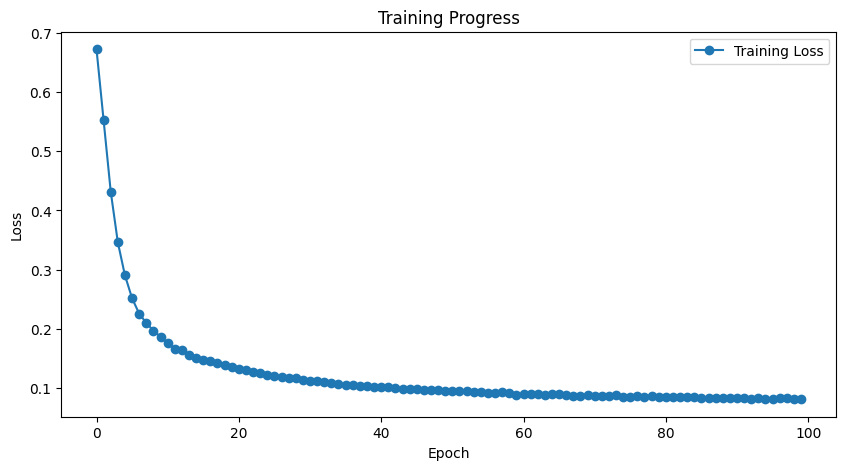

+------------------+-------------+----------+------------+---------------------+
| Label            |   Precision |   Recall |   F1-Score |   Balanced accuracy |
+==================+=============+==========+============+=====================+
| ambient          |      0.0000 |   0.0000 |     0.0000 |              0.4427 |
+------------------+-------------+----------+------------+---------------------+
| bass             |      0.0000 |   0.0000 |     0.0000 |              0.4793 |
+------------------+-------------+----------+------------+---------------------+
| chillout         |      0.0000 |   0.0000 |     0.0000 |              0.4783 |
+------------------+-------------+----------+------------+---------------------+
| classical        |      0.0000 |   0.0000 |     0.0000 |              0.4497 |
+------------------+-------------+----------+------------+---------------------+
| dance            |      0.0000 |   0.0000 |     0.0000 |              0.4916 |
+------------------+--------

In [237]:
device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 64

num_samples, sequence_length, num_features = train_feats.shape
X_train_flat = train_feats.reshape(num_samples, -1)
X_val_flat = test_feats.reshape(test_feats.shape[0], -1)

scaler = StandardScaler()
X_train_scaled_flat = scaler.fit_transform(X_train_flat)
X_val_scaled_flat = scaler.transform(X_val_flat)

X_train_scaled = X_train_scaled_flat.reshape(num_samples, sequence_length, num_features)
X_val_scaled = X_val_scaled_flat.reshape(test_feats.shape[0], sequence_length, num_features)

train_dataset = TensorDataset(torch.tensor(X_train_scaled).float(), torch.tensor(y_train).float())
val_dataset = TensorDataset(torch.tensor(X_val_scaled).float(), torch.tensor(y_test_encoder).float())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

model = MultilabelClassifier2D(sequence_length=sequence_length, input_dim=num_features, num_classes=num_classes)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, )

experiment = MultilabelExperiment(model, criterion, optimizer, train_loader, val_loader, device)
experiment.train(num_epochs=100)

y_pred, y_true = experiment.validate()
experiment.report_metrics(y_true, y_pred, labels=label_classes)

Во втором приближении будем пытаться понизить размерность по методу [отсюда](https://liverungrow.medium.com/sift-bag-of-features-svm-for-classification-b5f775d8e55f). Таким же образом мы делаем векторы осмысленнее - у них появляется физический смысл для всех одинаковый, в отличие от предыдущего подхода, где мы в разном порядке прокидывали элементы.

In [246]:
def build_histograms(dataset, vocab):
    feats = []
    vocab_size = vocab.shape[0]

    for descriptors in tqdm.tqdm(dataset):
        dist = cdist(descriptors, vocab, metric='euclidean')
        bin_assignment = np.argmin(dist, axis=1)

        image_feats = np.zeros(vocab_size)
        for id_assign in bin_assignment:
            image_feats[id_assign] += 1
        feats.append(image_feats)

    # Normalize histograms
    # feats = np.asarray(feats)
    # feats_norm_div = np.linalg.norm(feats, axis=1, keepdims=True)
    # feats = feats / feats_norm_div

    return np.array([[e] for e in feats])

In [240]:
all_descriptors = []
for sample in tqdm.tqdm(train_feats):
    all_descriptors.append(sample)
all_descriptors = np.vstack(all_descriptors)

n_clusters = 20  # Bag of Words size
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(all_descriptors)

vocab = kmeans.cluster_centers_

100%|██████████| 308/308 [00:00<00:00, 432.52it/s]


In [247]:
train_feats_bow = build_histograms(train_feats, vocab)
test_feats_bow = build_histograms(test_feats, vocab)

100%|██████████| 308/308 [00:00<00:00, 465.50it/s]


100%|██████████| 200/200 [00:14<00:00, 13.88it/s]


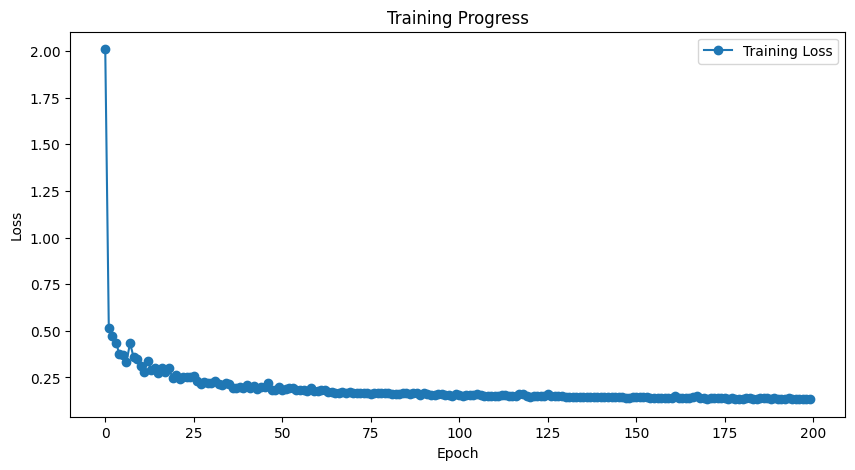

+------------------+-------------+----------+------------+---------------------+
| Label            |   Precision |   Recall |   F1-Score |   Balanced accuracy |
+==================+=============+==========+============+=====================+
| ambient          |      0.0000 |   0.0000 |     0.0000 |              0.4983 |
+------------------+-------------+----------+------------+---------------------+
| bass             |      0.0000 |   0.0000 |     0.0000 |              0.4948 |
+------------------+-------------+----------+------------+---------------------+
| chillout         |      0.0000 |   0.0000 |     0.0000 |              0.4883 |
+------------------+-------------+----------+------------+---------------------+
| classical        |      0.0741 |   0.1000 |     0.0851 |              0.5066 |
+------------------+-------------+----------+------------+---------------------+
| dance            |      0.0000 |   0.0000 |     0.0000 |              0.5000 |
+------------------+--------

In [248]:
device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 64

num_samples, sequence_length, num_features = train_feats_bow.shape

train_dataset = TensorDataset(torch.tensor(train_feats_bow).float(), torch.tensor(y_train).float())
val_dataset = TensorDataset(torch.tensor(test_feats_bow).float(), torch.tensor(y_test_encoder).float())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

model = MultilabelClassifier2D(sequence_length=sequence_length, input_dim=num_features, num_classes=num_classes)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, )

experiment = MultilabelExperiment(model, criterion, optimizer, train_loader, val_loader, device)
experiment.train(num_epochs=200)

y_pred, y_true = experiment.validate()
experiment.report_metrics(y_true, y_pred, labels=label_classes)

Для сравнения пропустим через сетку сглаженные вектора картинок.

100%|██████████| 100/100 [00:17<00:00,  5.86it/s]


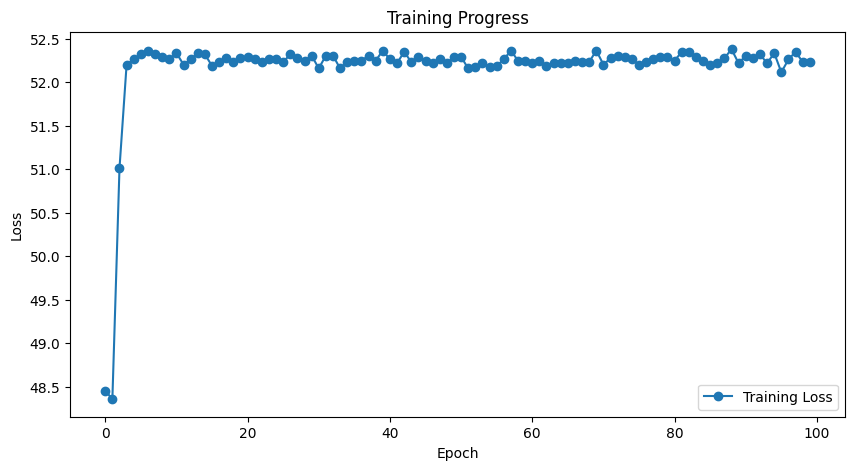

+------------------+-------------+----------+------------+---------------------+
| Label            |   Precision |   Recall |   F1-Score |   Balanced accuracy |
+==================+=============+==========+============+=====================+
| ambient          |      0.0649 |   1.0000 |     0.1220 |              0.5000 |
+------------------+-------------+----------+------------+---------------------+
| bass             |      0.0000 |   0.0000 |     0.0000 |              0.5000 |
+------------------+-------------+----------+------------+---------------------+
| chillout         |      0.0260 |   1.0000 |     0.0506 |              0.5000 |
+------------------+-------------+----------+------------+---------------------+
| classical        |      0.0000 |   0.0000 |     0.0000 |              0.5000 |
+------------------+-------------+----------+------------+---------------------+
| dance            |      0.0000 |   0.0000 |     0.0000 |              0.5000 |
+------------------+--------

In [243]:
device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 64

num_samples, sequence_length, num_features = train_feats_square.shape

train_dataset = TensorDataset(torch.tensor(train_feats_square).float(), torch.tensor(y_train).float())
val_dataset = TensorDataset(torch.tensor(test_feats_square).float(), torch.tensor(y_test_encoder).float())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

model = MultilabelClassifier2D(sequence_length=sequence_length, input_dim=num_features, num_classes=num_classes)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, )

experiment = MultilabelExperiment(model, criterion, optimizer, train_loader, val_loader, device)
experiment.train(num_epochs=100)

y_pred, y_true = experiment.validate()
experiment.report_metrics(y_true, y_pred, labels=label_classes)

Фэйл, не обучаемся совсем, попробуем использовать стандартизацию. Средняя точность очень плохая - около рандомно ставим

100%|██████████| 200/200 [00:31<00:00,  6.33it/s]


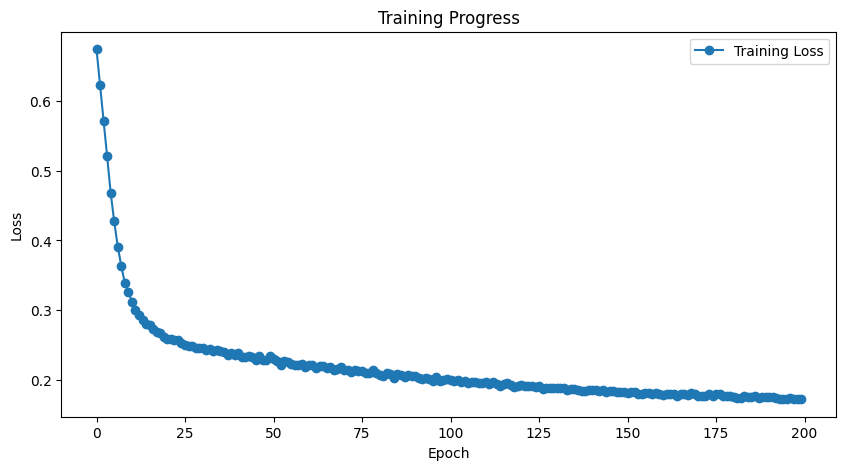

+------------------+-------------+----------+------------+---------------------+
| Label            |   Precision |   Recall |   F1-Score |   Balanced accuracy |
+==================+=============+==========+============+=====================+
| ambient          |      0.1818 |   0.1000 |     0.1290 |              0.5344 |
+------------------+-------------+----------+------------+---------------------+
| bass             |      0.0000 |   0.0000 |     0.0000 |              0.4983 |
+------------------+-------------+----------+------------+---------------------+
| chillout         |      0.0000 |   0.0000 |     0.0000 |              0.5000 |
+------------------+-------------+----------+------------+---------------------+
| classical        |      0.0370 |   0.0500 |     0.0426 |              0.4799 |
+------------------+-------------+----------+------------+---------------------+
| dance            |      0.0000 |   0.0000 |     0.0000 |              0.4967 |
+------------------+--------

In [242]:
device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 64

num_samples, sequence_length, num_features = train_feats_square.shape
X_train_flat = train_feats_square.reshape(num_samples, -1)
X_val_flat = test_feats_square.reshape(test_feats_square.shape[0], -1)

scaler = StandardScaler()
X_train_scaled_flat = scaler.fit_transform(X_train_flat)
X_val_scaled_flat = scaler.transform(X_val_flat)

X_train_scaled = X_train_scaled_flat.reshape(num_samples, sequence_length, num_features)
X_val_scaled = X_val_scaled_flat.reshape(test_feats_square.shape[0], sequence_length, num_features)

train_dataset = TensorDataset(torch.tensor(X_train_scaled).float(), torch.tensor(y_train).float())
val_dataset = TensorDataset(torch.tensor(X_val_scaled).float(), torch.tensor(y_test_encoder).float())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

model = MultilabelClassifier2D(sequence_length=sequence_length, input_dim=num_features, num_classes=num_classes)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, )

experiment = MultilabelExperiment(model, criterion, optimizer, train_loader, val_loader, device)
experiment.train(num_epochs=200)

y_pred, y_true = experiment.validate()
experiment.report_metrics(y_true, y_pred, labels=label_classes)

Заметим, что подход с SIFT показал наилучшие результаты в точности и по f1_score. Необходимо дальнейшее исследование гиперпараметров и развертывание идеи гистограмм. Также при демонстрации метрик необходимо учитывать разный вес входящих жанров на основе их встречаемости в датасете.